In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf /content/spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark import SparkContext
import time
from itertools import combinations
import numpy as np

In [3]:

def create_adjacency_graph(user_edges_rdd):
    rdd_1 = user_edges_rdd.groupByKey().mapValues(set)
    rdd_2 = user_edges_rdd.map(lambda x: (x[1], x[0])).groupByKey().mapValues(set)
    return rdd_1.union(rdd_2).reduceByKey(lambda x, y: x.union(y))


In [4]:
# Preprocessing

threshold = 4 # the filter threshold to generate edges between user nodes. If threshold is 2, two nodes are connected if they both review at least two same businesses

sc = SparkContext.getOrCreate()
rdd = sc.textFile("sample_data.txt")
# rdd = sc.textFile("gs://cps-534/sample_data.txt")
header = rdd.first()
rdd = rdd.filter(lambda line: line != header)
N = rdd.count()  # N is the number of rows (lines) in the textfile
print("number of rows: ", N)
rdd = rdd.map(lambda line: line.split(","))
print(rdd.take(2))

# find (user_id, {business1, business2, ...}) and save them in users_rdd:
users_rdd = rdd.map(lambda x: (x[0], x[1])).groupByKey().mapValues(set)

###############################################################################

# This code reduces the sample data
no_of_users = 20
indexed_users_rdd = users_rdd.zipWithIndex()
users_rdd = indexed_users_rdd.filter(lambda x: x[1] < no_of_users).map(lambda x : x[0])

###############################################################################
users_rdd.persist()
print("users_rdd take 1:", users_rdd.take(1)) # key is user_id, value is a set of all businesses that this user reviewed

# create users_dict dictionary (key, value) for fast search, since keys in dict are hashed
users_dict = dict(users_rdd.collect())

# get user_id information only:
distinct_users = users_rdd.keys().collect()

print("rdd: number of distinct users:", users_rdd.count())
print("dict: number of distinct users:", len(users_dict))

# let us create edges between users:
original_user_edges_list = []  # each item in original_user_edges_list is en edge connecting two users
for temp_user in combinations(distinct_users, 2): # for every two userIDs, check if the number of common businesses they reviewed is >= threshold
  if len(users_dict[temp_user[0]].intersection(users_dict[temp_user[1]])) >= threshold:
    edge_sort_key = tuple(sorted([temp_user[0], temp_user[1]]))
    original_user_edges_list.append(edge_sort_key)


# each item in user_edges_rdd is en edge connecting two users
user_edges_rdd = sc.parallelize(original_user_edges_list).persist()
print("user_edges_rdd take 2", user_edges_rdd.take(2))

# based on edges, we create an adjacency graph:
user_adjacency_rdd = create_adjacency_graph(user_edges_rdd) # each item in user_adjacency_rdd is (userID, a set of neighbors)
print("user_adjacency_rdd take 2", user_adjacency_rdd.take(2))

user_adjacency_dict = user_adjacency_rdd.collectAsMap()  # collectAsMap: return the key-value pairs in this RDD to the master as a dictionary.

print("user_adjacency_dict:",user_adjacency_dict)

node_degrees_dict = user_adjacency_rdd.map(lambda x: (x[0], len(x[1]))).collectAsMap() # collectAsMap: return the key-value pairs in this RDD to the master as a dictionary.

print("node_degrees_dict", node_degrees_dict)  # each item in this dict is 'userID' : node-degree


# now we have a graph, saved in user_edges_rdd

sc.stop()


# Adj graphs: user_adjacency_dict

number of rows:  38648
[['---1lKK3aKOuomHnwAkAow', 'uhb7nSskHRm5RFbGkGlGwQ'], ['---1lKK3aKOuomHnwAkAow', 'ebVPLAeD7FZ2VzY5ryOCxw']]
users_rdd take 1: [('---1lKK3aKOuomHnwAkAow', {'sKA6EOpxvBtCg7Ipuhl1RQ', '906qsOYOdCxUHhJm5T5YrQ', 'd8lmIZIqmBC9oPM8y1dc7Q', 'ZZF5iqlKFBWJSGSZzWHMzA', '9xjAQ9VlK6e46xy_iLzXqg', '0jHZk9RrKh0uRhTRW1XIqQ', 'zWo2a6QPIuC-sSJURJ02Hw', 'zKqWjDZHo-lk7_E3hHkORg', 'T70pMoTP008qYLsIvFCXdQ', 'kRSTvmQaiWB2Dk5dhxat7g', 'y0qIyD4Y1TzFjVo0LgFTiQ', 'pKk7jCFIm96qDdk0laVT2w', 'l_-4l8JwZbAn75Q1sfI7zQ', 'V_TxEdzeEs8P5nGPANOY7A', 'iA8Ve2sZKN5Vz3mYKrtCaQ', 'IP-q2lMq654sboZLwzYaig', 'ud45YT67UCbtNfRxNeR2Yg', 'GIlFumyLyrKu-3xA_xZNQg', 'FaHADZARwnY4yvlvpnsfGA', 'Td5dMlTHHnLHvo8Fg4SL1g', '7ZOTARscTr3opn4qLbbnZw', 'VOAO6ip7GwK4McQZbRa60g', 'mvLdgkwBzqllHWHwS-ZZgQ', 'ZbHE1ZncONeH-q93GuVGdA', 'Eg_M8eeu9SDEdbP7iUmVbQ', '6c9e9qH_AdBYQnm7dyiDAQ', '5CJL_2-XwCGBmOav4mFdYg', 'WMpXWa8iiEaDzb4vLTZjcw', 'rXKzE4Iraz7vGWovWW-aBA', '_ucDskZqK5w1QHkoA_nlRw', 'r8Jr-7YfkhJL2nxk9lxUNg', 'rgnvT2gHHfW_jW

In [5]:
# adjacency_matrix

keys = list(set(user_adjacency_dict.keys()))
index_of_keys = { i: index for index, i in enumerate(keys)}


size_of_keys = len(keys)

adjacency_matrix = [[ 0 for _ in range(size_of_keys)] for _ in range(size_of_keys)  ]

for key,values in user_adjacency_dict.items():
  i = index_of_keys[key]
  for value in values:
    if value in  index_of_keys:
      j = index_of_keys[value]
      adjacency_matrix[i][j] = 1

print(adjacency_matrix)


[[0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1], [1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1], [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1], [1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0]]


In [6]:
def expFunc(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def gradient(F, A, person):

  columns = F.shape[1]

  A_person = np.array(A[person])

  neighbours = np.where(A_person)
  not_neighbours = np.where(1-A_person)

  sum_neigh = np.zeros((columns,))
  for nb in neighbours[0]:
    dotproduct = F[nb].dot(F[person])   ## F[nb] = Fv , F[person] =  Fu
    sum_neigh += F[nb]*expFunc(dotproduct)

  sum_nneigh = np.zeros((columns,))
  for nnb in not_neighbours[0]:
    sum_nneigh += F[nnb]    ## F[nnb] = Fv

  grad = sum_neigh - sum_nneigh
  return grad


![Image Title](https://drive.google.com/uc?id=1mpcdd3zpg50dv1DDS-Gtkc3m5tFAjZA0)


In [7]:
def community_train(num_communities, adjacency_matrix, size_of_keys):
  F = np.random.rand(size_of_keys, num_communities)
  iterations =100
  for _ in range(iterations):
    # print(F)
    for person in range(size_of_keys):
      learning_rate = 0.01
      grad = gradient(F, adjacency_matrix, person)
      F[person] += learning_rate*grad
      F[person] = np.maximum(0.001, F[person]) # F should be nonnegative
    # log_likelihood =  likelihood(F, adjacency_matrix)

  F_argmax = np.argmax(F,1)

  user_communities = {}
  for i in range(size_of_keys):
    user_communities[keys[i]] = F_argmax[i]

  return F_argmax , user_communities



In [8]:
print(index_of_keys)

{'---1lKK3aKOuomHnwAkAow': 0, '--YhjyV-ce1nFLYxP49C5A': 1, '-EJorVxe7h2GSxdiRyMmDA': 2, '--RlSfc-QmcHFGHyX6aVjA': 3, '--2vR0DIsmQ6WfcSzKWigw': 4, '-8syaSLDbMXW2F2FApVgig': 5, '-50XWnmQGqBgEI-9ANvLlg': 6, '-267Yx8RmdP6io2-qI4UcQ': 7, '-Anyb0vB5LrW273whytNRw': 8, '-Fy91nyOFqPv9M_MaZ4W2g': 9, '-2kCxY7_aw5hOz7fJnGMbQ': 10, '-9da1xk7zgnnfO1uTVYGkA': 11, '-3s52C4zL_DHRK0ULG6qtg': 12, '-0HhZbPBlB1YZx3BhAfaEA': 13, '-7bM_DeL2Kj2CuYuVDsLNg': 14, '-ARdx8hOcEWlMDjzwLYZ_g': 15, '-9b4s874f_CnznTu4JorRg': 16}


Modularity

https://www.youtube.com/watch?v=Q_kJGm1xf6s


![Image Title](https://drive.google.com/uc?id=1UQYKlfqIbZdQ_332LbCF6z6DXJ64Rio3
)

In [11]:
# Modularity

Q_list = []
community_list = []
no_of_communities = 1
optimal_modularity = False
while( not optimal_modularity and no_of_communities < size_of_keys):
  F_argmax, user_communities = community_train(no_of_communities, adjacency_matrix, size_of_keys)
  no_of_edges = sum(list(node_degrees_dict.values()))

  div = 1/(2 * no_of_edges)
  edges_list = []
  for k,val in node_degrees_dict.items():
    edges_list.append(val)

  sum_modularity = 0
  for u in range(size_of_keys):
    for v in range(size_of_keys):
      if F_argmax[u] == F_argmax[v]:
        dou = 1
      else:
        dou = 0
      dudv = (edges_list[u]*edges_list[v])
      out = (adjacency_matrix[u][v] - (dudv * div))*dou
      sum_modularity = sum_modularity + out

  Q = div * sum_modularity
  Q_list.append(Q)
  community_list.append(no_of_communities)
  no_of_communities = no_of_communities + 1


In [12]:
# for i in range(len(Q_list)):
#   print("Communities: ",no_of_communities[i],", Modularity: ",Q_list[i])

print("Optimal number of communities : ", community_list[Q_list.index(max(Q_list))], " with Modularity : ",max(Q_list))

Optimal number of communities :  2  with Modularity :  0.3429752066115702


In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def graph_for_plot(user_communities,adjacency_matrix):
  # Create a graph
  G = nx.Graph()

  # Add nodes and edges based on user-community associations
  for user, community in user_communities.items():
      G.add_node(user, community=community)

  # Add edges between users based on the adjacency matrix
  for i in range(len(adjacency_matrix)):
      for j in range(i, len(adjacency_matrix[i])):
          if adjacency_matrix[i][j] == 1:
              user1 = list(user_communities.keys())[i]
              user2 = list(user_communities.keys())[j]
              G.add_edge(user1, user2)
  return G

In [16]:
F_argmax, user_communities = community_train(2, adjacency_matrix, size_of_keys)
G = graph_for_plot(user_communities,adjacency_matrix)

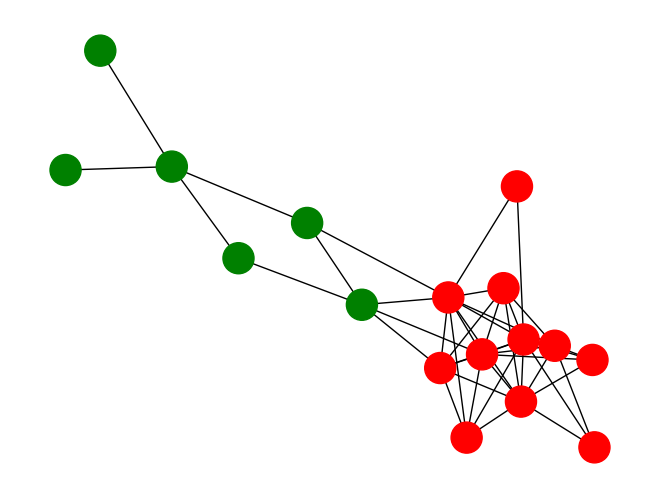

In [17]:


# Draw the graph with communities represented by colors
community_colors = {0: 'r', 1: 'g', 2: 'b', 3: 'y'}
node_colors = [community_colors[G.nodes[node]['community']] for node in G.nodes]

pos = nx.spring_layout(G)  # You can choose different layouts

nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=500)

plt.show()
